## Machine Learning II: Assignments #2

Group 3: Neelesh Bhalla, Chia-Jung Chang, Kirtesh Patel, Rhushikesh Bhosale, Nils Marthiensen

# Question 1

### Kernels

Based on the program developed in the lecture, implement a nonlinear
Kernel classifcation based on SVM for polynomial kernels (poly) and for
Gaussian Kernels, i.e., radial base functions (rbf). Apply the analysis to a
database of your choice, using the python code as provided (or your own).
Choose (and justify in a small text paragraph) two metrics to optimize for,
such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine
which combo of hyperparameters maximizes each of the two scores you
chose. It would be on you if you want to use GridSearch (as used in the
provided code), RandomSearch, or other methods such as hyperopt. It is
also on you to try other kernels of your choice. A 2-hyperparameter scan
is sufficient. Of course, you are free to scan more parameters, if useful and
interesting and doable for you. Do not forget to comment your choices
and results in short take-home statements. Data can be found everywhere,
e.g., at https://archive.ics.uci.edu/ml/index.php. No submissions based on
cancer or wine data! Have fun. It will be.

In [29]:
# Import of necessary libraries
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Description of the dataset

## MAGIC Gamma Telescope Data Set

This dataset contains information about a simulated telescope that detects high energy gamma particles. The telescope observes the radiation emitted by charged particles produced by gamma rays in the atmosphere. The dataset provides information about the patterns of the collected Cherenkov photons, which can be used to distinguish primary gamma rays from background cosmic rays.

The dataset includes 11 attributes such as the size, shape, and orientation of the patterns. The dataset was generated using a computer program called Corsika and can be used to compare different ways of identifying gamma rays from the background.

There are a total of 19020 tupels (rows) in the dataset.

More information about the dataset and the dataset itself can be found on this link - https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telesco

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm]
2. fWidth: continuous # minor axis of ellipse [mm]
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot]
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio]
5. fConc1: continuous # ratio of highest pixel over fSize [ratio]
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm]
7. fM3Long: continuous # 3rd root of third moment along major axis [mm]
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm]
9. fAlpha: continuous # angle of major axis with vector to origin [deg]
10. fDist: continuous # distance from origin to center of ellipse [mm]
11. class: g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 tupels in dataset

h = hadron (background): 6688 tupels in dataset

### Choice of dataset - REASON


The dataset was specifically chosen for its continutity in all the column values. There are zero categorical feature-columns which saves effort towards encoding and makes it a prefeered choice for tinkering with kernels.

In [30]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data',
                 names = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])
df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [31]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


Only the target feature is object variable. 
Rest all input features are float 64.
The dataset has no null values so further pre-processing is not needed.

In [32]:
# calculate the percentage of negative classes and print the result 
print("Percentage of negative classes: {:.2f}%".format((df["class"
].value_counts()[0] / len(df["class"])) * 100))
# calculate the percentage of positive classes and print the result 
print("Percentage of positive classes: {:.2f}%".format((df["class"
].value_counts()[1] / len(df["class"])) * 100))

Percentage of negative classes: 64.84%
Percentage of positive classes: 35.16%


In [33]:
# encoding the target column
le = LabelEncoder()
label = le.fit_transform(df['class'])
label

encoded_df = df.copy()
encoded_df.drop("class", axis=1, inplace=True)
encoded_df["class"] = label
encoded_df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [34]:
# down-sampling out rows from the dataset for SVM processing. Whole dataset will take a lot of time to be processed under grid search.
encoded_df_gamma = encoded_df[encoded_df['class']==0]
encoded_df_hadron = encoded_df[encoded_df['class']==1]

encoded_df_gamma_downsampled = resample (encoded_df_gamma, replace=False, n_samples=200, random_state=42)
encoded_df_hadron_downsampled = resample (encoded_df_hadron, replace=False, n_samples=200, random_state=42)

df_downsampled = pd.concat([encoded_df_gamma_downsampled,encoded_df_hadron_downsampled])

### Why did we do the downsampling?

At first we worked with the whole dataset. The positive and negative class were not balanced. This had a significant negative impact on the performance of the poly and rbf curves (They took a very long time to complete or did not complete at all). Only once we shrunk the dataset down and similtanously balanced the two classes, it became more efficient to handle. The curves completed quicker and we were actually able to derive some insights.

In [35]:
# Creating target and features
X = df_downsampled.drop(['class'], axis=1)
y = df_downsampled['class']

# scale the variables
sc = StandardScaler() 

X_scaled = sc.fit_transform(X)
print(X_scaled.shape)

# Split into train and test set and normalize data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.2) #, random_state = 0)

(400, 10)


In [36]:
# make f2 a valid validation
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

In [37]:
# SVM with polynomial kernel
# for score = f2 and f0.5
# hyperparameters gamma, C and degree, degree is the main one
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(degrees) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, C = Cs) # here C is fixed
        num_values = len(degrees)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="degree", param_range=degrees, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Degree'
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees
        ylim = [0, 1]
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

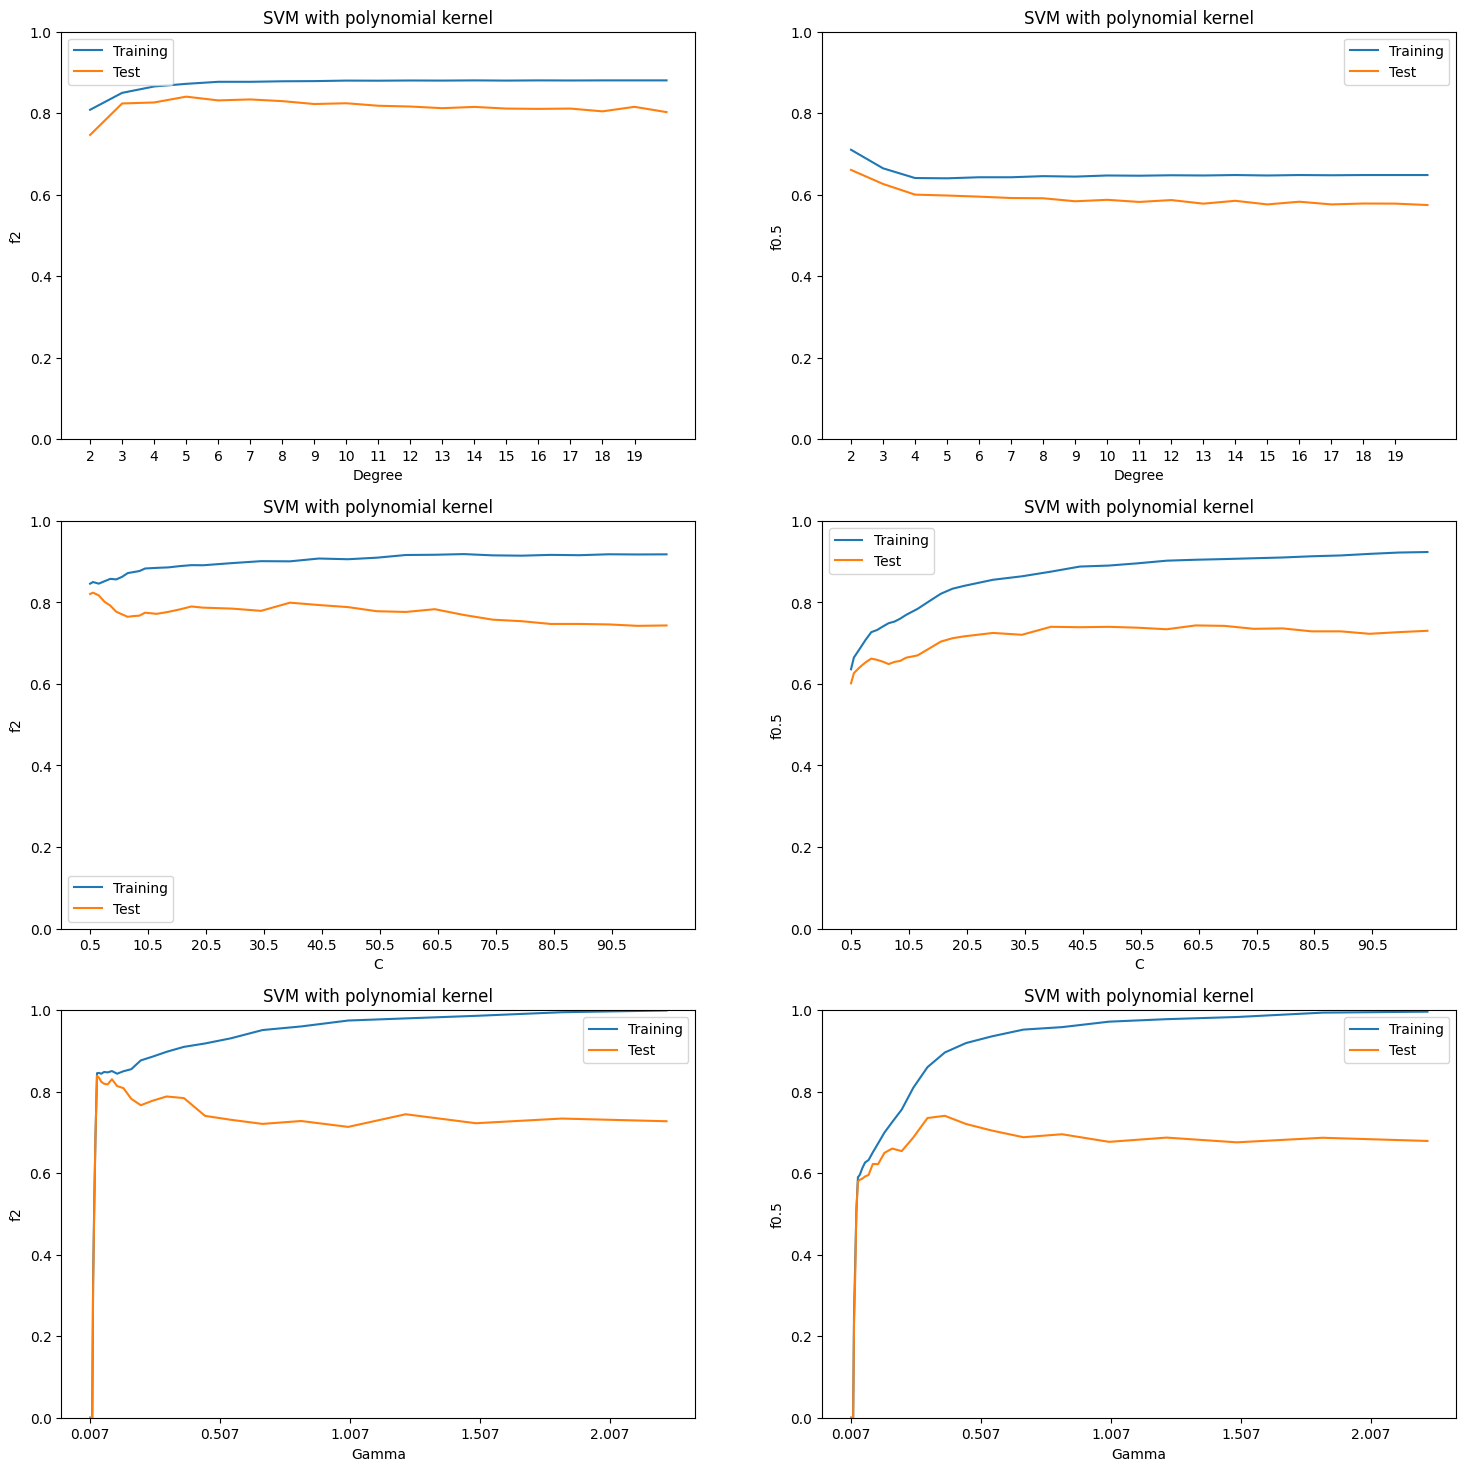

In [38]:
plt.figure(figsize = (18, 18))
degrees = np.arange(2, 21, 1) # choose/scan more systematically 
Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(3, 2, 1)
plot_poly_curve(degrees = degrees)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees = degrees, scoring = f05)
plt.subplot(3, 2, 3)
plot_poly_curve(Cs = Cs)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(3, 2, 5)
plot_poly_curve(gammas = gammas)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

In [39]:
# SVM with Gaussian(rbf) kernel

# The two functions can actually be integrated.
def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with rbf kernel')
    plt.legend()

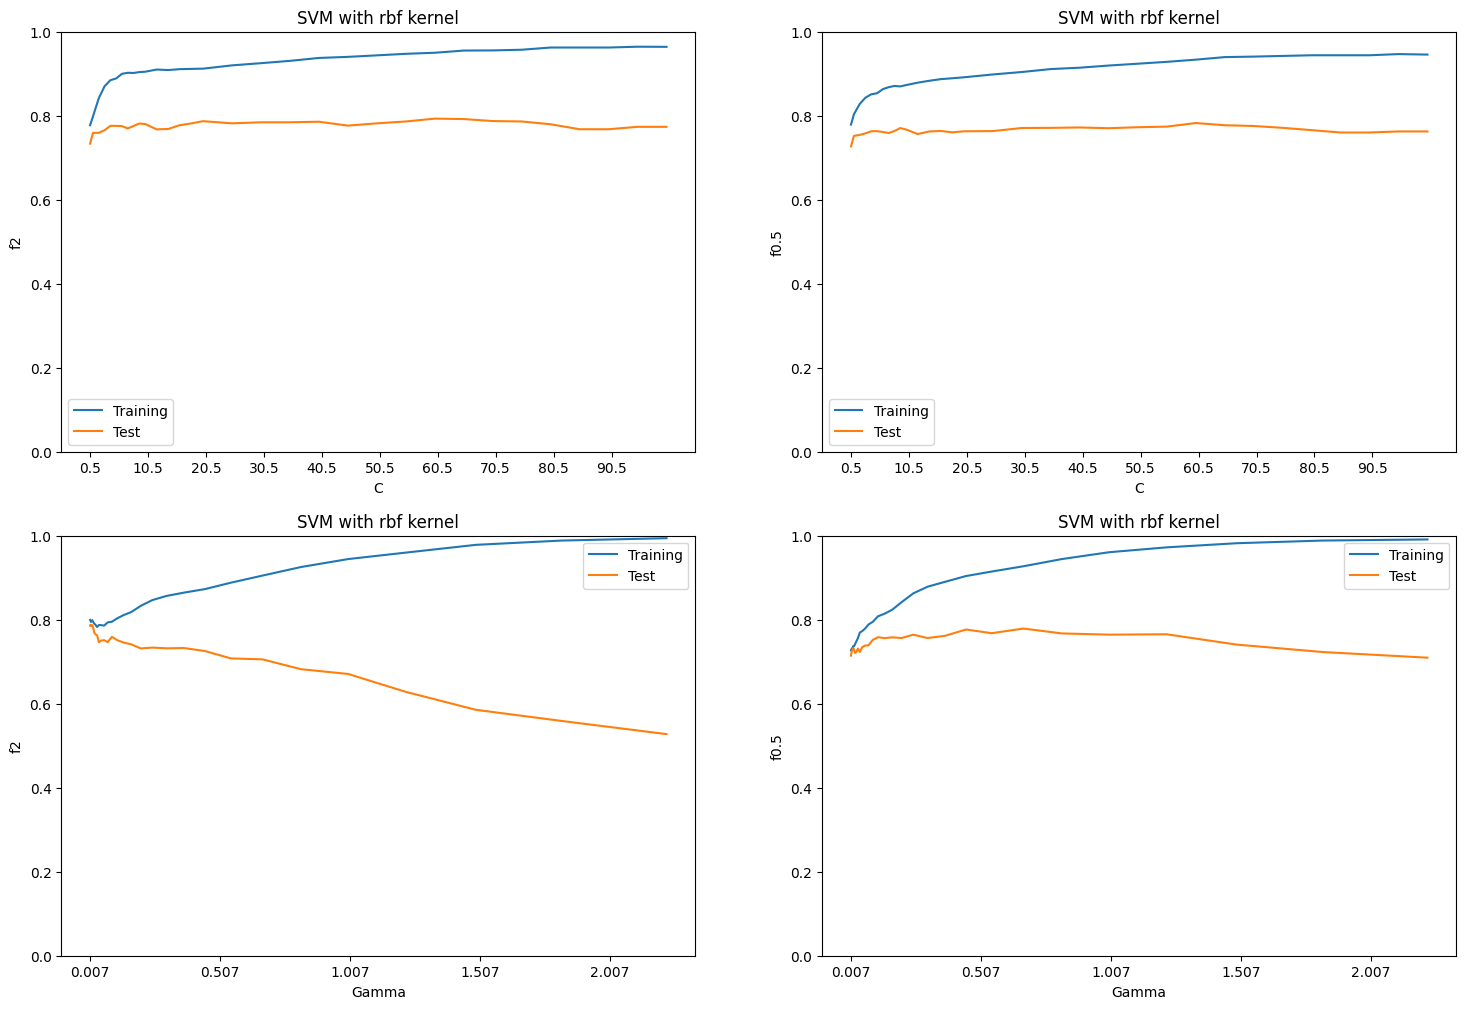

In [40]:
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)

plt.show()

In [41]:
# Grid Search to confirm the choice of kernel and check for other suitable hyperparameters
param_grid = {'kernel' : ['poly','rbf'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10,20],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 0.6,1],
              'degree' : [2, 3, 4]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1', 
           'f2' : f2,
           'f0.5' : f05}

svm_ = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 20],
                         'degree': [2, 3, 4], 'gamma': [0.1, 0.01, 0.1, 0.6, 1],
                         'kernel': ['poly', 'rbf']},
             refit='f2',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'f0.5': make_scorer(f05_scorer), 'f1': 'f1',
                      'f2': make_scorer(f2_scorer), 'recall': 'recall'})

In [42]:
# Saving the results of the Grid Search
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)
display(results)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_f2,std_test_f2,mean_test_f0.5,std_test_f0.5
0,0.001,2,0.10,poly,0.525000,0.007655,0.525000,0.007655,1.000000,0.000000,0.688491,0.006597,0.000000,0.000000,0.000000,0.000000
1,0.001,2,0.10,rbf,0.525000,0.007655,0.525000,0.007655,1.000000,0.000000,0.688491,0.006597,0.000000,0.000000,0.000000,0.000000
2,0.001,2,0.01,poly,0.525000,0.007655,0.525000,0.007655,1.000000,0.000000,0.688491,0.006597,0.000000,0.000000,0.000000,0.000000
3,0.001,2,0.01,rbf,0.525000,0.007655,0.525000,0.007655,1.000000,0.000000,0.688491,0.006597,0.000000,0.000000,0.000000,0.000000
4,0.001,2,0.10,poly,0.525000,0.007655,0.525000,0.007655,1.000000,0.000000,0.688491,0.006597,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,20.000,4,0.10,rbf,0.778125,0.030298,0.809286,0.040409,0.762210,0.085560,0.781059,0.037682,0.785594,0.042787,0.763695,0.044166
206,20.000,4,0.60,poly,0.656250,0.047393,0.693316,0.062952,0.631194,0.075400,0.657336,0.049923,0.669886,0.078559,0.636495,0.047825
207,20.000,4,0.60,rbf,0.743750,0.042619,0.749339,0.059104,0.779323,0.062654,0.761150,0.038761,0.710239,0.077838,0.734980,0.043106
208,20.000,4,1.00,poly,0.653125,0.044634,0.689283,0.062663,0.631194,0.075400,0.655229,0.047551,0.664241,0.078513,0.633477,0.044365


In [43]:
# results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
# results.loc[results.kernel == 'rbf', 'degree'] = np.nan
# results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,cln].head(10))
#display(results_sorted2.tail(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
192,poly,20.000,0.01,3,0.562500,1.000000,0.166845,0.281439,0.844488,0.576268
50,poly,0.010,0.10,4,0.540625,1.000000,0.125134,0.219199,0.837938,0.564127
80,poly,0.100,0.10,4,0.575000,0.923636,0.208556,0.336396,0.837103,0.582514
152,poly,10.000,0.01,2,0.584375,0.906494,0.232086,0.367454,0.836298,0.587636
8,poly,0.001,1.00,2,0.584375,0.906494,0.232086,0.367454,0.836298,0.587636
60,poly,0.100,0.10,2,0.584375,0.906494,0.232086,0.367454,0.836298,0.587636
16,poly,0.001,0.60,3,0.596875,0.872483,0.273975,0.415122,0.828572,0.594449
110,poly,0.500,0.10,4,0.593750,0.888333,0.267736,0.406166,0.827418,0.592338
70,poly,0.100,0.10,3,0.578125,0.866667,0.232442,0.364588,0.826730,0.583375
140,poly,1.000,0.10,4,0.600000,0.871970,0.285918,0.427576,0.825594,0.595969


In [44]:
results_sorted05 = results.sort_values('mean_test_f0.5', ascending = False)
results_sorted05.drop_duplicates(subset = results_sorted05.columns[3:], inplace = True) 
  
display(results_sorted05.loc[:,cln].head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
97,rbf,0.5,0.6,2,0.771875,0.738749,0.880927,0.802828,0.680427,0.786054
147,rbf,1.0,0.6,4,0.768750,0.750919,0.839394,0.792224,0.709588,0.771948
129,rbf,1.0,1.0,2,0.759375,0.731168,0.863280,0.790658,0.671752,0.769261
191,rbf,20.0,0.1,3,0.778125,0.809286,0.762210,0.781059,0.785594,0.763695
171,rbf,10.0,0.1,4,0.771875,0.807427,0.749911,0.774908,0.783553,0.753010
141,rbf,1.0,0.1,4,0.765625,0.782885,0.767558,0.774550,0.760041,0.751308
179,rbf,10.0,1.0,4,0.750000,0.738415,0.814973,0.773586,0.693847,0.749294
209,rbf,20.0,1.0,4,0.750000,0.738783,0.815152,0.774081,0.693779,0.748086
78,poly,0.1,1.0,3,0.753125,0.775735,0.750089,0.760964,0.751296,0.737693
207,rbf,20.0,0.6,4,0.743750,0.749339,0.779323,0.761150,0.710239,0.734980


In [45]:
C2 = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/X_train.shape[1])}   

svm_2 = svm.SVC(kernel = 'rbf', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = scoring, refit = 'f2')
CV_svm2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': array([  0.5,   1. ,   2. ,   3. ,   4. ,   5. ,   6. ,   7. ,   8. ,
         9. ,  10. ,  12. ,  14. ,  16. ,  18. ,  20. ,  25. ,  30. ,
        35. ,  40. ,  45. ,  50. ,  55. ,  60. ,  65. ,  70. ,  75. ,
        80. ,  85. ,  90. ,  95. , 100. ]),
                         'gamma': array([0.008, 0.01 , 0.012, 0.014, 0.016, 0.018, 0.02 , 0.022, 0.024,
       0.026, 0.028, 0.03 , 0.032, 0.034, 0.036, 0.038, 0.04 , 0.042,
       0.044, 0.046, 0.048, 0.05 , 0.1  ])},
             refit='f2',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'f0.5': make_scorer(f05_scorer), 'f1': 'f1',
                      'f2': make_scorer(f2_scorer), 'recall': 'recall'})

In [46]:
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_2] for k in params_2[0]}

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]

results2 = pd.DataFrame(result2)
results2.loc[:, 'kernel'] = 'rbf'
results_all = results.append(results2, ignore_index = True)

In [47]:
# Sort all results:
results_all_sorted2 = results_all.sort_values('mean_test_f2', ascending = False)
results_all_sorted2.index = range(len(results_all_sorted2))
results_all_sorted05 = results_all.sort_values('mean_test_f0.5', ascending = False)
results_all_sorted05.index = range(len(results_all_sorted05))
display(results_all_sorted2.head())
display(results_all_sorted05.head())

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_f2,std_test_f2,mean_test_f0.5,std_test_f0.5
0,20.00,3.0,0.01,poly,0.562500,0.032775,1.000000,0.000000,0.166845,0.058312,0.281439,0.090832,0.844488,0.010745,0.576268,0.019544
1,0.01,4.0,0.10,poly,0.540625,0.027243,1.000000,0.000000,0.125134,0.047902,0.219199,0.075997,0.837938,0.009179,0.564127,0.016635
2,0.10,4.0,0.10,poly,0.575000,0.031869,0.923636,0.093703,0.208556,0.057021,0.336396,0.077619,0.837103,0.018826,0.582514,0.019769
3,10.00,2.0,0.01,poly,0.584375,0.027243,0.906494,0.077662,0.232086,0.047180,0.367454,0.062676,0.836298,0.017667,0.587636,0.016177
4,0.10,2.0,0.10,poly,0.584375,0.027243,0.906494,0.077662,0.232086,0.047180,0.367454,0.062676,0.836298,0.017667,0.587636,0.016177


,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_f2,std_test_f2,mean_test_f0.5,std_test_f0.5
0,0.5,3.0,0.600,rbf,0.771875,0.03776,0.738749,0.047006,0.880927,0.001747,0.802828,0.028178,0.680427,0.068360,0.786054,0.033021
1,0.5,4.0,0.600,rbf,0.771875,0.03776,0.738749,0.047006,0.880927,0.001747,0.802828,0.028178,0.680427,0.068360,0.786054,0.033021
2,0.5,2.0,0.600,rbf,0.771875,0.03776,0.738749,0.047006,0.880927,0.001747,0.802828,0.028178,0.680427,0.068360,0.786054,0.033021
3,85.0,NaN,0.048,rbf,0.800000,0.03878,0.837339,0.041804,0.774153,0.096556,0.800003,0.047536,0.815059,0.037607,0.784474,0.054927
4,95.0,NaN,0.046,rbf,0.800000,0.03878,0.837339,0.041804,0.774153,0.096556,0.800003,0.047536,0.815059,0.037607,0.784474,0.054927


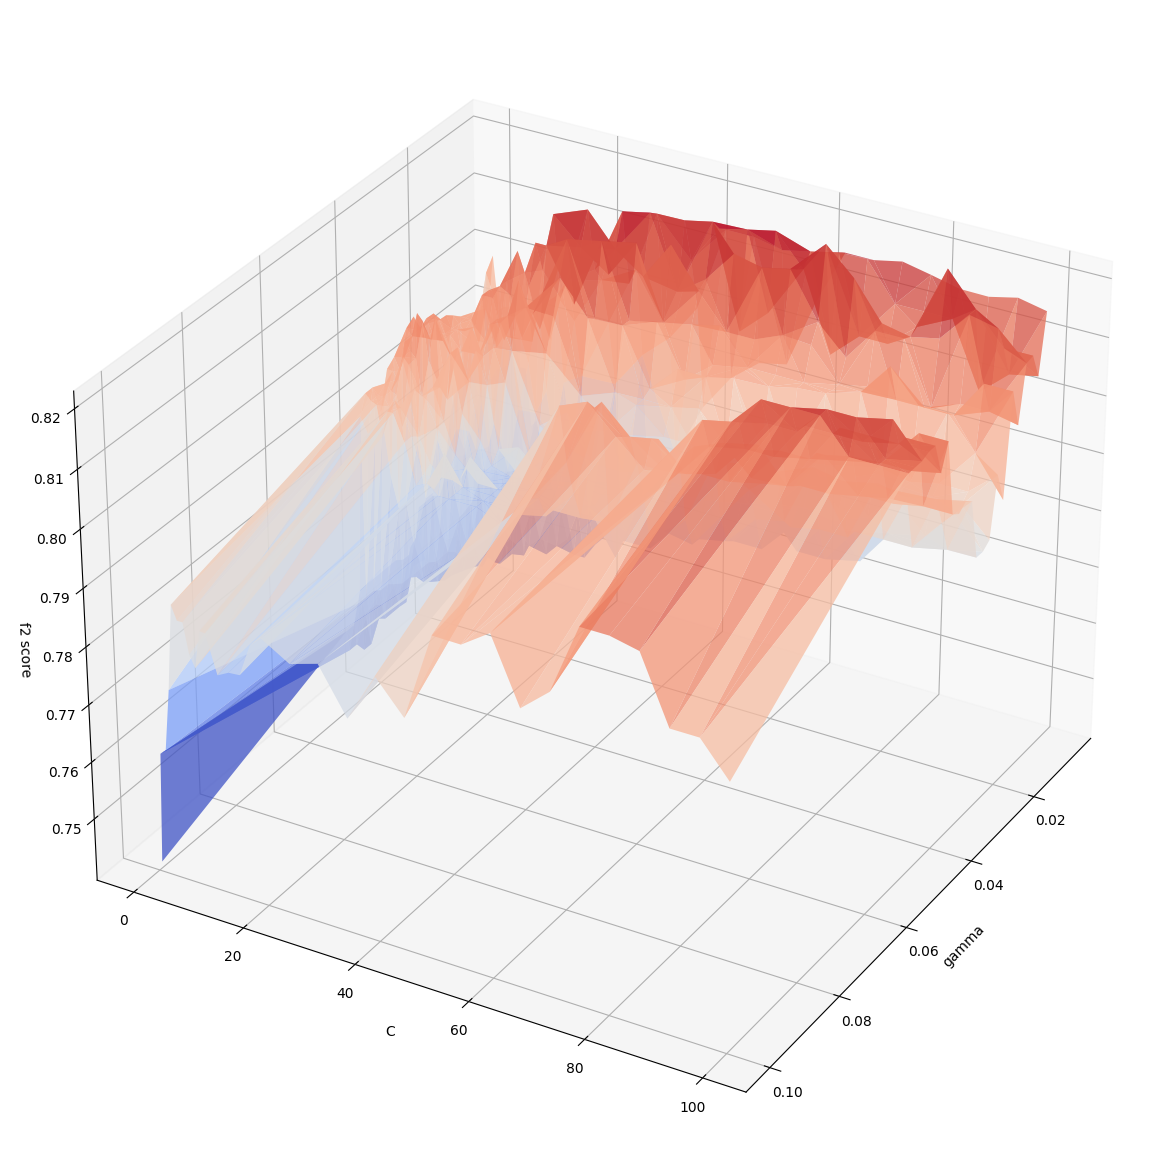

In [48]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results2.gamma, results2.C, results2.mean_test_f2, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f2 score')
ax.view_init(azim=30)    # rotation
plt.show()

In [49]:
# We use the best one for f2:
print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = svm.SVC(C = results_all_sorted2.loc[0, 'C'], 
                     gamma = results_all_sorted2.loc[0, 'gamma'],
                     kernel = results_all_sorted2.loc[0, 'kernel'])
                     #random_state = 0)
svm_bestf2.fit(X_train, y_train)

y_train_pred = svm_bestf2.predict(X_train)
y_test_pred = svm_bestf2.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f2_train = f2_scorer(y_train, y_train_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of training sample: ', f2_train)
print('f2 score of test sample: ', f2_test)

C         20.0
gamma     0.01
kernel    poly
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[152   0]
 [136  32]]
Confusion matrix of test sample: 
 [[48  0]
 [28  4]]
f2 score of training sample:  0.8482142857142857
f2 score of test sample:  0.8955223880597015


In [50]:
# We use the best one for f0.5:
print(results_all_sorted05.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf05 = svm.SVC(C = results_all_sorted05.loc[0, 'C'], 
                      gamma = results_all_sorted05.loc[0, 'gamma'],
                      kernel = results_all_sorted05.loc[0, 'kernel'],
                      random_state = 0)
svm_bestf05.fit(X_train, y_train)

y_train_pred = svm_bestf05.predict(X_train)
y_test_pred = svm_bestf05.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f05_train = f05_scorer(y_train, y_train_pred)
f05_test = f05_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f0.5 score of training sample: ', f05_train)
print('f0.5 score of test sample: ', f05_test)

C         0.5
gamma     0.6
kernel    rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[118  34]
 [ 12 156]]
Confusion matrix of test sample: 
 [[30 18]
 [ 1 31]]
f0.5 score of training sample:  0.8779761904761905
f0.5 score of test sample:  0.8720930232558141


The confusion matrix are shown above.

## Take home message:


The F2 score gives more weight to recall, while the F0.5 score gives more weight to precision.
The polynomial kenel model has higher f2 score signifying higher recall and less f0.5 score signfying lower precision. So it's not suitable for applications where precision is an important factor.  
In rbf kernel the f2 and f0.5 scores are balanced, i.e equal weightage to both precision and recall scores. 
In our case we are not considering analysis of a disease in which false negative is more problamatic. So in our case precision and recall are not as relevant performance metrices. But it does make sense to check out the extreme cases i.e. high weight on recall or high weight on precision instead of going for a normal f1 score.

In both the kernels poly and rbf, the effect of Cs on f scores is more or less that same. Algothough variation of f scores with gamma is more prominent. Though rbf kernel has more converged f0.5 score for training and test data compared to the poly kernal. This signifies that rbf is less of an overfit compared to poly kernel.

Rbf shows higher overfit for larger values of gamma, as the plot suggests.
In poly kernel degree doesn't have a significant effect on the f scores compared to other variables such as gamma and C.

Due the results, the best Kernel to classify between people with Magic Gamma dataset in this dataset is RBF with C=0.5 and gamma=0.6 for best f0.5 score.
Due the results, the best Kernel to classify between people with Magic Gamma dataset in this dataset is RBF with C=0.01 and gamma=20 for best f2 score.

The performance of the models for both kernels is affected by the value of C, which controls the degree of regularization. When C is very small, the models do not perform well, as high regularization hinders the model's ability to capture complex patterns in the data. On the other hand, a large value of C introduces overfitting, resulting in high scores on the training data but poor performance on the test data.

Furthermore, increasing the value of gamma generally improves the model's performance initially, but beyond a certain point, further increases in gamma lead to a dramatic decrease in performance. This phenomenon can be explained by the fact that gamma controls the influence of individual training examples on the model's decision boundary. When gamma is too small, the model may be too simplistic and fail to capture important patterns in the data. However, as gamma increases, the model becomes too complex and may fit noise in the data, leading to poor performance on unseen data.